In [26]:
import rhinoinside
rhinoinside.load()
import System
import Rhino.Geometry as rg
from Rhino.Geometry import Point3d, Plane, Brep, Vector3d
from Rhino.Geometry import Surface as RhinoSurface
from Rhino.Geometry import Polyline
from Rhino.Collections import Point3dList
from Rhino.Geometry import PolylineCurve
from Rhino.Geometry import Transform
from Rhino.FileIO import File3dm

import time
import numpy as np

PARAMETRAGE

In [27]:
# Paramètres de configuration
GRID_SIZE = 100 # Taille du champ de panneau pour la simulation
ENTRAXE = 2.5 # Espacement entre lignes de panneaux (= inter-rang)
HAUTEUR = 3 # [0 ; 100] ; mètres ; hauter de l'axe de rotation, ou du point du PVP le plus bas.
RAMPANT = 1.135 # Largeur du panneau
NB_RANGS = 20 # Nombre de panneaux par ligne
NB_PVP_RANGS = int(GRID_SIZE / ENTRAXE) # Nombre de lignes
LONGUEUR_PVP = GRID_SIZE / (NB_RANGS) # Longueur des panneaux dans une même ligne

column_spacing = ENTRAXE # Espacement entre lignes de panneaux (= inter-rang)
row_spacing = GRID_SIZE / NB_RANGS # Espacement entre panneaux d'une même ligne (même support)

ANGLE_ORIENTATION = 45  # Rotation globale autour de l'axe Z
ANGLE_VARIABLE = -30  # Angle de rotation individuelle autour de l'axe X

GEOMETRY

In [28]:
def create_surface(x, y, length, width):
    
    points = Point3dList()
    points.Add(x, y, 0)
    points.Add(x + width, y, 0),
    points.Add(x + width, y + length, 0),
    points.Add(x, y + length, 0),
    points.Add(x, y, 0)

    # Créer une polyline
    polyline = PolylineCurve(points)
    
    # Vérifier si la polyline est fermée
    if polyline.IsClosed:
        # Créer une extrusion de la polyline
        direction = Vector3d(0, 0, 0.001)  # Direction d'extrusion (minimale pour simuler une surface)
        surface = RhinoSurface.CreateExtrusion(polyline, direction)  # Extrusion minime
        return surface
    else:
        return None

In [29]:
def create_and_rotate_grid(nb_rangs, nb_pvp_rangs, width, length, column_spacing, row_spacing, angle_orientation, angle_variable):
    grid_surfaces = []

    for i in range(nb_rangs):
        for j in range(nb_pvp_rangs):
            x = (j * column_spacing) - GRID_SIZE / 2
            y = (i * row_spacing) - GRID_SIZE / 2
            surface = create_surface(x, y, length, width)
            if surface:
                # Rotation autour de l'axe X pour chaque Brep individuellement
                center_of_surface = Point3d(x + length / 2, y + width / 2, 0)
                rotation_x = Transform.Rotation(angle_variable * (System.Math.PI / 180), Vector3d.YAxis, center_of_surface)
                surface.Transform(rotation_x)
                grid_surfaces.append(surface.ToBrep())

    # Assembler tous les Brep en un seul
    final_brep = rg.Brep()
    for brep in grid_surfaces:
        final_brep.Append(brep)
 
    # Rotation globale autour de l'axe Z au centre de la grille (origine)
    rotation_z = Transform.Rotation(angle_orientation * (System.Math.PI / 180), Vector3d.ZAxis, rg.Point3d.Origin)
    final_brep.Transform(rotation_z)

    # Translation globale sur l'axe Z, équivalente à la hauteur de l'entraxe
    translation_z = Transform.Translation(0,0,HAUTEUR)
    final_brep.Transform(translation_z)
    
    return final_brep

In [30]:
### VISUALISATION AVEC RHINO
def export_brep_to_file(brep, filename):
    file = File3dm()
    file.Objects.AddBrep(brep)
    file.Write(filename, 7)  # Version 7 pour Rhino 7

In [31]:
final_rotated_brep = create_and_rotate_grid(NB_RANGS, NB_PVP_RANGS, RAMPANT, LONGUEUR_PVP, column_spacing, row_spacing, ANGLE_ORIENTATION, ANGLE_VARIABLE)

### VISUALISATION AVEC RHINO
export_brep_to_file(final_rotated_brep, "output2.3dm")

In [32]:
# Paramètres de la grille
taille_totale = 10  # La taille totale de la grille
longueur_cote = 10  # Longueur du côté de chaque surface carrée
nombre_surfaces = int(taille_totale / longueur_cote)  # Nombre de surfaces par ligne et colonne

# Calcul de la position initiale pour centrer la grille
debut_x = -taille_totale / 2 
debut_y = -taille_totale / 2 

print(debut_x)
print(debut_y)

# Création de l'objet Brep pour assembler toutes les surfaces
grille_breps = rg.Brep()
liste_breps = []

# Création des surfaces et ajout à l'objet Brep
for i in range(nombre_surfaces):
    for j in range(nombre_surfaces):
        x = debut_x + j * longueur_cote  # Position x de la surface courante
        y = debut_y + i * longueur_cote  # Position y de la surface courante
        surface_brep = create_surface(x, y, longueur_cote, longueur_cote)
        if surface_brep:
            grille_breps.Append(surface_brep.ToBrep())
            liste_breps.append(surface_brep.ToBrep())

-5.0
-5.0


In [33]:
# ##VISUALISATION
# # Ouverture du fichier .3dm existant
file_path = "output2.3dm"
file = File3dm.Read(file_path)
if surface_brep:
    file.Objects.AddBrep(surface_brep.ToBrep())
    file.Write(file_path,7)  # Réécrire le fichier avec la nouvelle géométrie ajoutée
    print("La nouvelle géométrie a été ajoutée au fichier existant.")
else:
    print("Erreur lors de la création de la surface.")

La nouvelle géométrie a été ajoutée au fichier existant.


IMPORT_EPW

In [34]:
from __future__ import division

import collections
import array
import math
try:
    import Rhino.UI as rui
except ImportError as e:
    raise ImportError("Failed to import Rhino.\n{}".format(e))
import ladybug.epw as epw

In [35]:
_epw_file_path = "FRA_AC_Agen-La.Garenne.AP.075240_TMYx.epw"

epw_data = epw.EPW(_epw_file_path)
location_ = epw_data.location #######
direct_normal_rad_ = epw_data.direct_normal_radiation #########
diffuse_horizontal_rad_ = epw_data.diffuse_horizontal_radiation #########

SKY_MATRIX

In [36]:
#IMPORTS SKYMATRIX
try:
    from ladybug_geometry.geometry2d.pointvector import Vector2D
except ImportError as e:
    raise ImportError('\nFailed to import ladybug_geometry:\n\t{}'.format(e))

try:
    from ladybug_radiance.skymatrix import SkyMatrix
except ImportError as e:
    raise ImportError('\nFailed to import ladybug:\n\t{}'.format(e))

try:
    from ladybug_rhino.togeometry import to_vector2d
except ImportError as e:
    raise ImportError('\nFailed to import ladybug_rhino:\n\t{}'.format(e))

try:
    from lbt_recipes.version import check_radiance_date
except ImportError as e:
    raise ImportError('\nFailed to import honeybee_radiance:\n\t{}'.format(e))

# check the istalled Radiance date and get the path to the gemdaymtx executable
check_radiance_date()

In [37]:
###SKY MATRIX
# process and set defaults for all of the global inputs
north_ = None
_location = location_
_direct_rad = direct_normal_rad_
_diffuse_rad = diffuse_horizontal_rad_
_folder_ = "C:/Users/maceo.valente/Documents/Automatisation/TEST_MVA/TSAgriPV/cielMatrices"
 
if north_ is not None:  # process the north_
    try:
        north_ = math.degrees(
            to_vector2d(north_).angle_clockwise(Vector2D(0, 1)))
    except AttributeError:  # north angle instead of vector
        north_ = float(north_)

# create the sky matrix object
sky_mtx_to_IR = SkyMatrix.from_components(
    _location, _direct_rad, _diffuse_rad, 
    #_hoys_, north_, high_density_, ground_r
    )
if _folder_:
    sky_mtx_to_IR.folder = _folder_

print(sky_mtx_to_IR)

SkyMatrix [Agen-La.Garenne.AP]


Imports pour Incident Radiation et Fonctions Grasshopper

In [38]:
#IMPORTS FOR INCIDENT RADIATION
try:
    from ladybug.viewsphere import view_sphere
    from ladybug.graphic import GraphicContainer
    from ladybug.legend import LegendParameters
    from ladybug.color import Colorset
except ImportError as e:
    raise ImportError('\nFailed to import ladybug:\n\t{}'.format(e))

try:
    from ladybug_rhino.config import conversion_to_meters
    from ladybug_rhino.togeometry import to_joined_gridded_mesh3d
    from ladybug_rhino.fromgeometry import from_mesh3d, from_point3d, from_vector3d
except ImportError as e:
    raise ImportError('\nFailed to import ladybug_rhino:\n\t{}'.format(e))

try:
    from ladybug_rhino.intersect import intersect_mesh_rays, join_geometry_to_mesh
    #from ladybug_rhino.text import text_objects
    #from ladybug_rhino.fromobjects import legend_objects
except ImportError as e:
    raise ImportError('\nFailed to import ladybug function :\n\t{}'.format(e))

In [39]:
#FONCTIONS GH
def objectify_output(object_name, output_data):
    """Wrap data into a single custom Python object that can later be de-serialized.

    This is meant to address the same issue as the wrap_output method but it does
    so by simply hiding the individual items from the Grasshopper UI within a custom
    parent object that other components can accept as input and de-objectify to
    get access to the data. This strategy is also useful for the case of standard
    object types like integers where the large number of data points slows down
    the Grasshopper UI when they are output.

    Args:
        object_name: Text for the name of the custom object that will wrap the data.
            This is how the object will display in the Grasshopper UI.
        output_data: A list of data to be stored under the data property of
            the output object.
    """
    class Objectifier(object):
        """Generic class for objectifying data."""

        def __init__(self, name, data):
            self.name = name
            self.data = data

        def ToString(self):
            return '{} ({} items)'.format(self.name, len(self.data))

    return Objectifier(object_name, output_data)

def de_objectify_output(objectified_data):
    """Extract the data from an object that was output from the objectify_output method.

    Args:
        objectified_data: An object that has been output from the objectify_output
            method for which data will be returned.
    """
    return objectified_data.data

def text_objects(text, plane, height, font='Arial',
                 horizontal_alignment=0, vertical_alignment=5):
    """Generate a Bake-able Grasshopper text object from a text string and ladybug Plane.

    Args:
        text: A text string to be converted to a a Grasshopper text object.
        plane: A Ladybug Plane object to locate and orient the text in the Rhino scene.
        height: A number for the height of the text in the Rhino scene.
        font: An optional text string for the font in which to draw the text.
        horizontal_alignment: An optional integer to specify the horizontal alignment
             of the text. Choose from: (0 = Left, 1 = Center, 2 = Right)
        vertical_alignment: An optional integer to specify the vertical alignment
             of the text. Choose from: (0 = Top, 1 = MiddleOfTop, 2 = BottomOfTop,
             3 = Middle, 4 = MiddleOfBottom, 5 = Bottom, 6 = BottomOfBoundingBox)
    """
    txt = Rhino.Display.Text3d(text, from_plane(plane), height)
    txt.FontFace = font
    txt.HorizontalAlignment = AlignmentTypes.horizontal(horizontal_alignment)
    txt.VerticalAlignment = AlignmentTypes.vertical(vertical_alignment)
    return TextGoo(txt)


Incident Radiation

In [40]:
###INCIDENT RADIATION

#Paramètres d'entrée :
_sky_mtx_in_IR = sky_mtx_to_IR
_geometry = liste_breps
context_ = final_rotated_brep
_grid_size = 1 # Finesse
_offset_dist_ = 0.5 # Hauteur de récupération des données (0.5 = 50cm ?)
irradiance_ = True # False : resultats exprimés en irradiance cumulée à l'année kWh/m^2 ; True : resultats exprimés en irradiance moyenne (W/m^2)
legend_par_ = None #set to default

# set the default offset distance and _cpu_count
_offset_dist_ = _offset_dist_ if _offset_dist_ is not None \
    else 0.5 / conversion_to_meters()
workers = 1 # _cpu_count_ if _cpu_count_ is not None else recommended_processor_count()

# create the gridded mesh from the geometry
study_mesh = to_joined_gridded_mesh3d(_geometry, _grid_size)
points = [from_point3d(pt.move(vec * _offset_dist_)) for pt, vec in
          zip(study_mesh.face_centroids, study_mesh.face_normals)]

# mesh the geometry and context
shade_mesh = join_geometry_to_mesh(_geometry + [context_])

# deconstruct the matrix and get the sky dome vectors
mtx_temp_IR = de_objectify_output(_sky_mtx_in_IR)
total_sky_rad = [dir_rad + dif_rad for dir_rad, dif_rad in zip(mtx_temp_IR[1], mtx_temp_IR[2])]
ground_rad = [(sum(total_sky_rad) / len(total_sky_rad)) * mtx_temp_IR[0][1]] * len(total_sky_rad)
all_rad = total_sky_rad + ground_rad 
lb_vecs = view_sphere.tregenza_dome_vectors if len(total_sky_rad) == 145 \
    else view_sphere.reinhart_dome_vectors
if mtx_temp_IR[0][0] != 0:  # there is a north input for sky; rotate vectors
    north_angle = math.radians(mtx_temp_IR[0][0])
    lb_vecs = tuple(vec.rotate_xy(north_angle) for vec in lb_vecs)
lb_grnd_vecs = tuple(vec.reverse() for vec in lb_vecs)
all_vecs = [from_vector3d(vec) for vec in lb_vecs + lb_grnd_vecs]

# intersect the rays with the mesh
normals = [from_vector3d(vec) for vec in study_mesh.face_normals]
int_matrix_init, angles = intersect_mesh_rays(
    shade_mesh, points, all_vecs, normals, cpu_count=workers)

# compute the results
results = []
int_matrix = []
for int_vals, angs in zip(int_matrix_init, angles):
    pt_rel = [ival * math.cos(ang) for ival, ang in zip(int_vals, angs)]
    int_matrix.append(pt_rel)
    rad_result = sum(r * w for r, w in zip(pt_rel, all_rad))
    results.append(rad_result)

# convert to irradiance if requested -> PAS EXECUTE
if irradiance_:
    factor = 1000 / _sky_mtx_in_IR.wea_duration if hasattr(_sky_mtx_in_IR, 'wea_duration') \
        else 1000 / (((mtx_temp_IR[0][3] - mtx_temp_IR[0][2]).total_seconds() / 3600) + 1)
    results = [r * factor for r in results]

# output the intersection matrix and compute total radiation
int_mtx_to_RTIR = objectify_output('Geometry/Sky Intersection Matrix', int_matrix)
unit_conv = conversion_to_meters() ** 2
total = 0
for rad, area in zip(results, study_mesh.face_areas):
    total += rad * area * unit_conv


In [41]:
# start_time = time.time()
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Le temps d'exécution est de {elapsed_time:.3f} secondes.")

BOUCLE IV : Pour chaque heure de l'année, calculer une nouvelle sky_mtx et appliquer LB Real Time Incident Radiation avec la int_mtx créée lors de LB Incident Radiation

In [42]:
from datetime import datetime, timedelta
import ladybug.analysisperiod as ap

# Définir le début et la fin de l'année
start_date = datetime(year=2023, month=1, day=1, hour=8)  # Début de l'année
end_date = datetime(year=2024, month=1, day=1, hour=0)  # Fin de l'année (début de l'année suivante)

# Boucle sur chaque heure de l'année
current_date = start_date
int_mtx_temp_in_RTIR = de_objectify_output(int_mtx_to_RTIR)
columns = []

while current_date < end_date:
    ###############
    ####BOUCLE IV##
    ###############

    if current_date.hour >= 20:
        # Passer au jour suivant à 8h
        current_date += timedelta(days=1)  # Ajoute un jour
        current_date = current_date.replace(hour=8)  # Change l'heure à 8h
        continue

    ##Analysis Period##-----------------

    anp = ap.AnalysisPeriod(
        current_date.month, current_date.day, current_date.hour, # STARTING DATES
        next_date.month, next_date.day, next_date.hour, # ENDING DATES
        1) # TIMESTEP PER HOUR (SET TO 1)
    hoys_sm = anp.hoys
    

    ##Analysis Period##-----------------
    ##Temporary SkyMatrix##-------------

    sky_mtx_boucle = SkyMatrix.from_components(
        location = location_,
        direct_normal_irradiance = direct_normal_rad_,
        diffuse_horizontal_irradiance = diffuse_horizontal_rad_,
        hoys=hoys_sm)
    if _folder_:
        sky_mtx_boucle.folder = _folder_

    ##Temporary SkyMatrix##-------------
    ##LB RTIR##-------------------------

    sky_mtx_temp_RTIR = de_objectify_output(sky_mtx_boucle)
    total_sky_rad = [dirr + difr for dirr, difr in zip(sky_mtx_temp_RTIR[1], sky_mtx_temp_RTIR[2])]
    ground_rad = [(sum(total_sky_rad) / len(total_sky_rad)) * sky_mtx_temp_RTIR[0][1]] * len(total_sky_rad)
    all_rad = total_sky_rad + ground_rad 
    results_RTIR = []
    for pt_rel in int_mtx_temp_in_RTIR:
        results_RTIR.append(sum(r * w for r, w in zip(pt_rel, all_rad)))
    columns.append(results_RTIR)

    ##LB RTIR##-------------------------

    current_date += timedelta(hours=1)  # Incrémenter de une heure

    ###############
    ####BOUCLE IV##
    ###############

data = np.column_stack(columns)

Garder 8h - 20h ; tester 6h - 22h
Réduire la géométrie
Etudier impact de différence entre 1° et 5° (pas)

Localiser les résultas



In [44]:
print(len(data[0]))
print(len(data))
print(8760/2)


4380
40
4380.0


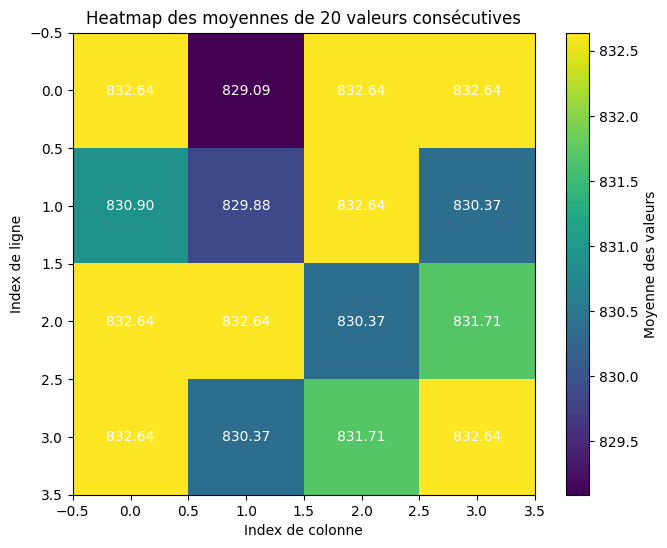

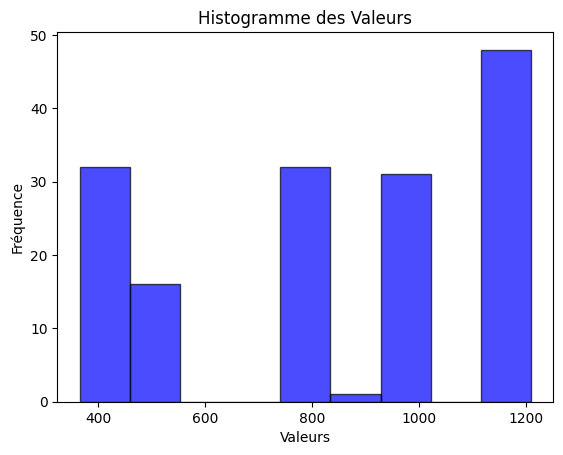

In [18]:
#VISU GRAPHIQUE DES RESULTATS
import numpy as np
import matplotlib.pyplot as plt

# Génération de données aléatoires pour l'exemple
data = results
# Calculer les moyennes pour chaque bloc de 100 valeurs
averages = [np.mean(data[i:i+10]) for i in range(0, 40, 10)]

# Créer une matrice 4x4 à partir de ces moyennes
matrix = np.array(averages).reshape(4, 4)

# Créer un heatmap
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Moyenne des valeurs')
plt.title('Heatmap des moyennes de 20 valeurs consécutives')
plt.xlabel('Index de colonne')
plt.ylabel('Index de ligne')

# Ajouter les annotations pour chaque case
for i in range(4):
    for j in range(4):
        plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white')

plt.show()

plt.hist(data, bins='auto', alpha=0.7, color='blue', edgecolor='black')

# Ajouter des titres et des labels
plt.title('Histogramme des Valeurs')
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')

# Afficher l'histogramme
plt.show()